## Intercomparison of 3D Radiation Codes (I3RC): https://i3rc.gsfc.nasa.gov/
-----

##### Description
I3RC is an ongoing project initiated in the late 1990s. Its goals include: 
- Comparing methods available for 3D atmospheric radiative transfer calculations.
- Providing benchmark results for testing and debugging 3D radiative transfer codes.
- Publishing an open source toolkit (community 3D Monte Carlo code).
- Helping atmospheric science education by creating an archive of illustrative images and other resources on 3D radiative transfer.

Benchmark test-cases are devided into three phases. This test implements them for the mitsuba-renderer (https://www.mitsuba-renderer.org/), comparing it to gold-standard atmospheric science codes.


##### Phase I
Includes several baseline radiative computations for 3D radiative transfer through the following cloud fields:
1. 1D academic 'step' cloud field
2. 2D field derived from the ARM cloud radar
3. 3D field derived from radiances measured by the Landsat Thematic Mapper instrument

These computations involved cloud and surface only (i.e., no gases or aerosol) and were monochromatic, with scattering and absorption only (i.e., no emission), and were completed independently at each participants' home institutions.


### 1D academic step cloud field
---
#### Scenario 
- X-direction: $32$ columns (pixels): 16 have an optical depth of $\tau=2$. The remaining have $\tau=18$. Total size is 0.5km, thus $dx=0.5/32~ {\rm km}$.
- Y-direction: infinite.
- Z-direction: Geometrical thickness is set to 0.25 km everywhere (flat cloud).

  This is the Readme file for I3RC Case 1 (Step cloud) consensus results.                                              
  This file can be obtained at http://i3rc.gsfc.nasa.gov/consensus_result/consensus_result_case1.tar    
---
#### Experiments
ASSUMPTIONS:
1. No atmospheric effects
2. Periodic boundary conditions (cloud field is repeated an infinite
   number of times along the x direction)
3. Henyey-Greenstein phase function (PF) with g=0.85
4. Black (zero reflectance) surface
5. Single scattering albedos w0=1 and w0=0.99 (with the same PF
   and extinction field).

SOLAR GEOMETRY: 
1. Sun at (SZA of) zero degrees
2. Sun at 60 degrees and 0 azimuth (Sun shining from low x coordinates)

This makes a total of 2x2=4 experiments:

      Exp.#    
        1:      SZA = 0,  w0 = 1
        2:      SZA = 60, w0 = 1
        3:      SZA = 0,  w0 = 0.99
        4:      SZA = 60, w0 = 0.99
---
#### Output

Mean and higher order moments of: 
   1. albedo (R)
   2. transmittance (T)
   3. absorptance (wherever applicable) (A)
   4. net horizontal flux (H) defined as $1-R-T-A$
   5. nadir reflectivity (Iu) defined as $\pi\nu / (F \mu_0)$ where: 
       - $\nu$ - upward exiting radiance at 0 degrees
       - $\mu_0$ - cosine of the solar zenith angle
       - $F=1$ is the incident solar flux
   6. oblique reflectivities (Io) defined as $\pi N_o / (F\mu_0)$ where:
       - $N_o$ - upward exiting radiance at 60 degrees zenith and 0 and 180 degrees azimuth angles (i.e. two oblique reflectivities are requested)
   7. zenith transmissivity (Id) defined as $\pi N_d/(F\mu_0)$ where:
       - $N_d$ - downward exiting radiance at 180 degrees (requested only when SZA=60)


Higher order moments are calculated as 
$$ \frac{1}{N}\sum_{i=1}^N (x_i-\bar{x})^k, \quad k=2,6 \quad  N=32$$

---
#### Consensus Results : http://i3rc.gsfc.nasa.gov/consensus_result/consensus_result_case1.tar
   File format: I3RC_cons_res_case1_exp#_RQ.txt 
   1.   "exp#" is the experiment number as listed above; valid number are 1-4 for this case
   2.  "RQ" is the radiative quantity contained the file. RQ takes the following values:
       - RQ=R     (reflectance)
       - RQ=T     (transmittance)
       - RQ=A     (absorptance)
       - RQ=H     (net horizontal flux)
       - RQ=Iu    (nadir reflectivity)
       - RQ=I601  (reflectivity at 60 view, 0 azimuth)
       - RQ=I602  (reflectivity at 60 view, 180 azimuth)
       - RQ=Id    (zenith transmissivity) 

In [88]:
# Mitsuba imports
from mitsuba.core import *
from mitsuba.render import Scene, RenderQueue, RenderJob

# Multiprocessing imports and initialization
import multiprocessing
scheduler = Scheduler.getInstance()

# Start up the scheduling system with one worker per local core
for i in range(0, multiprocessing.cpu_count()): 
    scheduler.registerWorker(LocalWorker(i, 'wrk%i' % i))


# Other imports and function defenitions 
import numpy as np
import matplotlib.pyplot as plt

def plot(x,y):
    f, ax = plt.subplots(figsize=(5,2))
    ax.imshow(beta_field.T, aspect=5, origin='lower')
    ax.set_xticks([0,(x.size-1)/2,x.size-1])
    ax.set_yticks([-0.5,0.5])
    ax.set_xticklabels([x[0],x[(x.size-1)/2],x[-1]])
    ax.set_yticklabels([0,0.25])
    plt.xlabel('[km]') 
    plt.ylabel('[km]')
    plt.title(r'1D step cloud $\beta(x)$')
    for x_pos in [8,24]:
        ax.text(x_pos, 0, r'$\beta$=%1.1f' %beta_field[x_pos], color='r', fontsize=16, va='center', ha='center')
    plt.show()
  
import os, sys, struct
import numpy as np

def vol2data(filename):
    """
    Generates 3d matrix (ndarray) from a binary file modified as .vol type
    Input:  filename - .vol file name
    Output: volData - 3D matrix of float representing the voxels values of the object
            boundingBox - bounding box of the object [xmin,ymin,zmin],[xmax,ymax,zmax]
    """
    fid = open(filename, 'rb')
    
    # Reading first 48 bytes of volFileName as header , count begins from zero  
    header = fid.read(48)  
    
    # Converting header bytes 8-21 to volume size [xsize,ysize,zsize] , type = I : 32 bit integer
    size = struct.unpack(3*'I', bytearray(header[8:20]))

    # Converting header bytes 24-47 to bounding box [xmin,ymin,zmin],[xmax,ymax,zmax] type = f : 32 bit float
    boundingBox = struct.unpack(6*'f', bytearray(header[24:48]))

    # Converting data bytes 49-* to a 3D matrix size of [xsize,ysize,zsize], 
    # type = f : 32 bit float   
    bindata = fid.read()
    nCells = size[0]*size[1]*size[2]
    volData = np.array(struct.unpack(nCells*'f', bytearray(bindata)))
    volData = volData.reshape(size, order='F')

    fid.close()
    
    return volData, boundingBox

def data2vol(volData, boundingBox, filename):
    """
    Generates a binary file (.vol) from a 3d matrix (numpy array)  
    Input: volData - 3D matrix of float representing the voxels values of the object
           boundingBox - bounding box of the object [xmin,ymin,zmin],[xmax,ymax,zmax]
           filename - .vol file name
    Output: Binary (.vol) file
    """
    
    fid = open(filename, 'wb')
    fid.write('VOL')                       # Bytes 1-3 ASCII Bytes 'V', 'O', and 'L'
    fid.write(struct.pack('B',3))          # Byte 4 File format version number (currently 3)
    fid.write(struct.pack('I',1))          # Bytes 5-8 Encoding identifier (32-bit integer).The following choices are available:
                                           #       1. Dense float32-based representation
                                           #       2. Dense float16-based representation (currently not supported by this implementation)       
                                           #       3. Dense uint8-based representation (The range 0..255 will be mapped to 0..1)
                                           #       4. Dense quantized directions. The
                                           #       directions are stored in spherical coordinates with a total storage cost of 16 bit per entry.
    
    # Add dimensions to reach a 4D structure (fourth dimention for multi-spectral data)
    for i in range(volData.ndim, 4):
        volData = volData[...,np.newaxis]
    shape = volData.shape
    ncells = shape[0]*shape[1]*shape[2]
    
    fid.write(struct.pack(4*'I',*shape))    # Bytes 9-24 Number of cells along the X,Y,Z axes (32 bit integer); Bytes 21-24 Number of channels (32 bit integer, supported values: 1 or 3)           
    fid.write(struct.pack(6*'f',*boundingBox))      # Bytes 25-48 Axis-aligned bounding box of the data stored in single precision order: (xmin, ymin, zmin, xmax, ymax, zmax)

    # Write the data: Bytes 49-*
    # Binary data of the volume stored in the specified encoding. The data are ordered so that the following C-style indexing operationmakes sense
    # after the file has been mapped into memory: data[((zpos*yres + ypos)*xres + xpos)*channels + chan]
    # where (xpos, ypos, zpos, chan) denotes the lookup location.
    fid.write(struct.pack('f'*ncells, *volData.ravel(order='F')));

    fid.close()
    
    return 

<IPython.core.display.Javascript object>


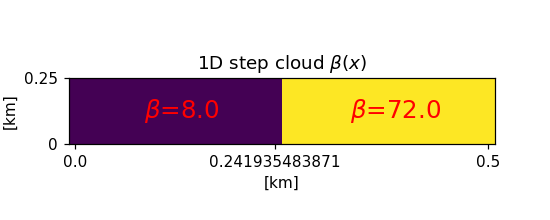

In [89]:
# Create a \beta field and plot it: 1D step cloud field

tau_field = np.vstack((np.full([16,1], 2.00), np.full([16,1], 18.00)))
z_extent = 0.25
beta_field = tau_field/z_extent
x_axis = np.linspace(0,0.5, beta_field.size)
data2vol(volData=beta_field, boundingBox=[0,0,0,0.5,0.5,0.25], filename='step.vol')


%matplotlib notebook 
plot(x_axis, beta_field)

In [86]:
scene = Scene()
pmgr = PluginManager.getInstance()

# Create a sensor, film & sample generator
scene.addChild(pmgr.create({
    'type' : 'perspective',
    'fov' : 60.0,
    'toWorld' : Transform.lookAt(
        Point(0.25, 0.25, 1.0),   # Camera position
        Point(0.25, 0.25, 0.0),    # Target vector
        Vector(0.0, 1.0, 0.0)      # Up vector
    ),
    'film' : {
        'type' : 'mfilm',
        'width' : 700,
        'height' : 700,
        'fileFormat' : 'numpy'
    },
    'sampler' : {
        'type' : 'ldsampler',
        'sampleCount' : 16
    }
}))

# Set the integrator
scene.addChild(pmgr.create({
    'type' : 'volpath',
    'maxDepth' : 8
}))


scene.addChild(pmgr.create({
    'type' : 'heterogeneous',
    'method' : 'woodcock',
    'density' : {
        'type' : 'gridvolume',
        'filename' : 'step.vol'
    },
    'albedo' : {
        'type' : 'constvolume',
          'value' : Spectrum(0.99)
    },
    'scale' : 1.0
}))


scene.addChild(pmgr.create({
    'type' : 'sun',
    'sunDirection' : Vector(0.0, 0.0, 1.0)
}))


scene.addChild(pmgr.create({
    'type' : 'cube',
    'toWorld' : Transform.translate(Vector(1.0, 1.0, 1.0)),
    'toWorld' : Transform.scale(Vector(0.25, 0.25, 0.125)),
    'bsdf' : {
        'type' : 'diffuse'
    }
}))

scene.configure()

<IPython.core.display.Javascript object>


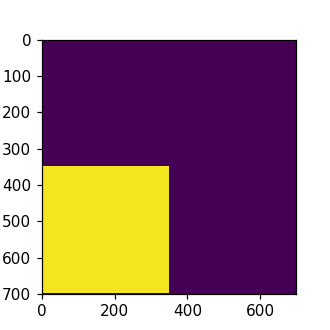

In [87]:
# Create a queue for tracking render jobs
scheduler.start()
queue = RenderQueue()

# Create a render job and insert it into the queue
job = RenderJob('myRenderJob', scene, queue)
job.start()
queue.waitLeft(0)
queue.join()
scheduler.stop()

# Develop the camera's film into an 8 bit sRGB bitmap
film = scene.getFilm()
size = film.getSize()
bitmap = Bitmap(Bitmap.ELuminance, Bitmap.EFloat32, size) 
film.develop(Point2i(0, 0), size, Point2i(0, 0), bitmap)

%matplotlib notebook
plt.figure(figsize=(3,3))
bitmap.plot()

True True


In [32]:
v = np.empty((3,3,3))
a = np.array(v.shape)
struct.pack(3*'I', *a)


'\x03\x00\x00\x00\x03\x00\x00\x00\x03\x00\x00\x00'

In [105]:
fid = open('smoke.vol', 'rb')
header = fid.read(9)
fid.close()

struct.unpack('B',header[3])
header[:3]

'VOL'

In [38]:
class MyFormatter(Formatter):
    def format(self, logLevel, sourceClass, sourceThread, message, filename, line):
        
        return '%s (log level: %s, thread: %s, class %s, file %s, line %i)' % \
                   (message, str(logLevel), sourceThread.getName(), sourceClass, filename, line)
        
class MyAppender(Appender):
    def append(self, logLevel, message):
        print(message)
        
    def logProgress(self, progress, name, formatted, eta):
        print('Progress message: ' + formatted)
        
# Get the logger associated with the current thread
logger = Thread.getThread().getLogger()
logger.setFormatter(MyFormatter())
logger.clearAppenders()
logger.addAppender(MyAppender())
logger.setLogLevel(EDebug)
Log(EInfo, 'Test message')

HeterogeneousMedium[
  density = ref<CachingDataSource>[ref=1, ptr=CachingDataSource[unknown]],
  albedo = ref<ConstantDataSource>[ref=1, ptr=ConstantDataSource[value=[0.9, 0.9, 0.9]]],
  orientation = ref<VolumeDataSource>[null],
  stepSize = 0.00393701,
  scale = 100
]